In [9]:
from azure.storage.blob import BlobServiceClient
from io import StringIO
import pandas as pd

CONNECTION_STRING = "DefaultEndpointsProtocol=https;AccountName=llmprojectstorage001;AccountKey=Yxy9YBn27iWV1lc2m7sUaLZBA4z16tY9P0prYbUDWfnAP9VDz1j9E5kKCU8AcTihq7WDzpVC2W0y+AStydZk9Q==;EndpointSuffix=core.windows.net"
CONTAINER_NAME = "llmdatasets"
BLOB_NAME = "llm_conversation_preference_dataset.csv"

try:
    print("Connecting and downloading file...")
    blob_service_client = BlobServiceClient.from_connection_string(CONNECTION_STRING)
    blob_client = blob_service_client.get_blob_client(container=CONTAINER_NAME, blob=BLOB_NAME)

    download_stream = blob_client.download_blob()
    data_content = download_stream.readall().decode('utf-8')

    df = pd.read_csv(StringIO(data_content))
    print("✅ SUCCESS! Here's your data:")
    print(df.head())

except Exception as e:
    print(f"❌ FAILED: {e}")


Connecting and downloading file...
✅ SUCCESS! Here's your data:
                        conversation_id                   timestamp  \
0  b17a22ff-6828-4eaf-a9b4-f4b042621f95  2025-03-09T11:49:28.368491   
1  a98ba087-3497-4216-9d5b-300be09fbe00  2025-05-08T11:49:28.368742   
2  d64a0373-c80b-4741-8d95-36f9ddd6f667  2025-04-21T11:49:28.368927   
3  eb1032a8-bd15-47d4-9476-969961bc633e  2025-04-07T11:49:28.369084   
4  f519a698-8981-4b56-8c0a-df59732339e6  2025-05-22T11:49:28.369223   

     session_id                     topic conversation_style  \
0  session_5741     Cryptocurrency & DeFi        Informative   
1  session_9797          Digital Wellness         Analytical   
2  session_2104            Urban Planning    Problem-solving   
3  session_8973             Healthcare AI         Persuasive   
4  session_3200  Future of Transportation         Persuasive   

   conversation_length complexity_level  \
0                    6           Medium   
1                    7           Mediu

In [10]:
df.groupby('model_a')['reasoning_quality'].mean().sort_values(ascending=False)


model_a
LLaMA-3-70B          0.756488
Mixtral-8x7B         0.754513
Claude-3.5-Sonnet    0.750334
PaLM-2               0.749701
GPT-4o               0.749504
GPT-4-Turbo          0.749067
Claude-4-Sonnet      0.748392
Vicuna-33B           0.747988
Command-R+           0.746253
Gemini-Pro-1.5       0.745051
GPT-3.5-Turbo        0.744315
WizardLM-70B         0.740958
Name: reasoning_quality, dtype: float64

In [11]:
df.groupby('topic')[['instruction_following', 'factual_consistency']].mean().sort_values(by='instruction_following')


,instruction_following,factual_consistency
topic,,
Gene Therapy,0.842568,0.900741
Political Polarization,0.845526,0.900611
Space Exploration,0.845671,0.894911
Climate Change Solutions,0.845690,0.897476
Mental Health Support,0.846207,0.899261
Urban Planning,0.846839,0.896865
Biotechnology Ethics,0.847232,0.900209
Cybersecurity,0.848157,0.904263
Healthcare AI,0.848398,0.900284


In [12]:
df.groupby('a_b_test_variant')['conversation_depth_score'].mean().sort_values(ascending=False)


a_b_test_variant
enhanced_context    0.655182
baseline            0.650728
improved_prompt     0.644700
Name: conversation_depth_score, dtype: float64

In [13]:
df_filtered = df[(df['model_a'] == 'GPT-4o') | (df['model_b'] == 'GPT-4o') |
                 (df['model_a'] == 'Claude-3.5-Sonnet') | (df['model_b'] == 'Claude-3.5-Sonnet')]
df_filtered[['response_time_a_ms', 'response_time_b_ms']].describe()


,response_time_a_ms,response_time_b_ms
count,3199.000000,3199.000000
mean,2037.156924,1731.635511
std,2185.150143,717.381457
min,500.000000,501.000000
25%,1127.000000,1111.500000
50%,1752.000000,1738.000000
75%,2398.000000,2330.000000
max,20000.000000,2996.000000


In [14]:
df['quality_per_ms'] = df['reasoning_quality'] / df['response_time_a_ms']
df.groupby('model_a')['quality_per_ms'].mean().sort_values(ascending=False)


model_a
Vicuna-33B           0.000548
Mixtral-8x7B         0.000537
Gemini-Pro-1.5       0.000533
Claude-4-Sonnet      0.000532
PaLM-2               0.000532
LLaMA-3-70B          0.000528
GPT-4o               0.000524
GPT-4-Turbo          0.000523
WizardLM-70B         0.000522
Command-R+           0.000521
Claude-3.5-Sonnet    0.000519
GPT-3.5-Turbo        0.000493
Name: quality_per_ms, dtype: float64

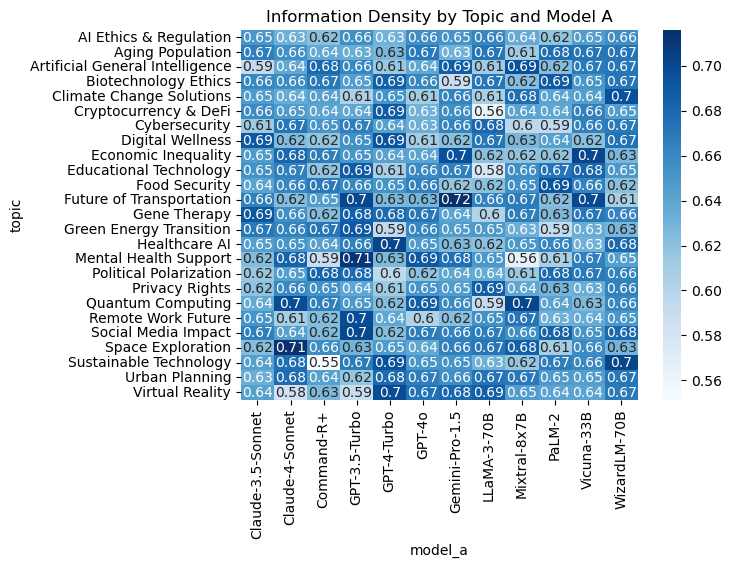

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
pivot = df.pivot_table(values='information_density', index='topic', columns='model_a', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='Blues')
plt.title('Information Density by Topic and Model A')
plt.show()

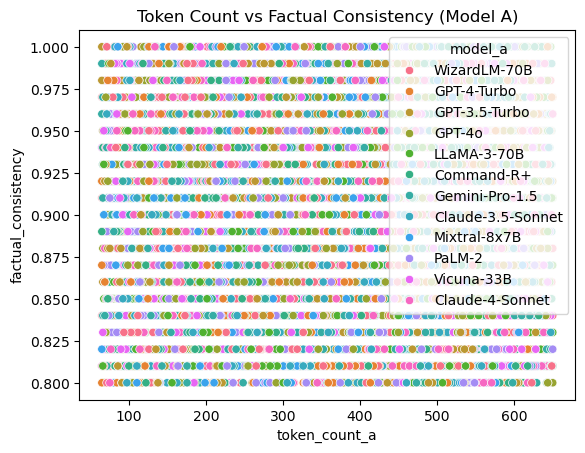

In [17]:
sns.scatterplot(data=df, x='token_count_a', y='factual_consistency', hue='model_a')
plt.title('Token Count vs Factual Consistency (Model A)')
plt.show()

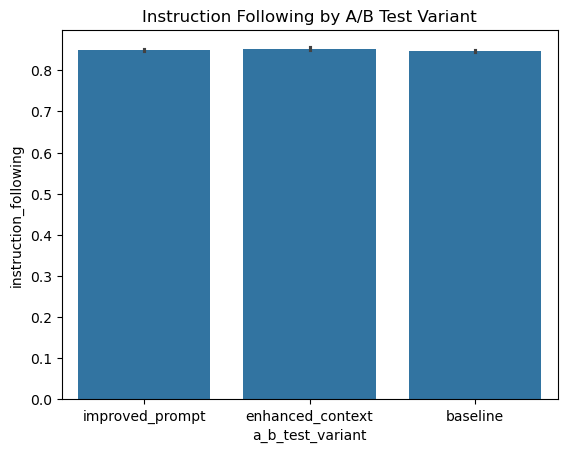

In [18]:
sns.barplot(data=df, x='a_b_test_variant', y='instruction_following')
plt.title('Instruction Following by A/B Test Variant')
plt.show()

In [19]:
model_usage = df['model_a'].value_counts().to_frame(name='usage')
model_quality = df.groupby('model_a')[['factual_consistency', 'response_time_a_ms']].mean()
underrated_models = model_usage.join(model_quality)
underrated_models.sort_values(by=['factual_consistency', 'response_time_a_ms'], ascending=[False, True])


,usage,factual_consistency,response_time_a_ms
model_a,,,
LLaMA-3-70B,803,0.901382,1976.901619
PaLM-2,836,0.900789,2000.776316
Claude-3.5-Sonnet,809,0.900779,2153.043263
GPT-3.5-Turbo,818,0.900477,2120.545232
Gemini-Pro-1.5,877,0.900433,1955.881414
Claude-4-Sonnet,877,0.899624,1873.244014
WizardLM-70B,898,0.899577,2021.685969
GPT-4-Turbo,750,0.899147,2047.412000
GPT-4o,847,0.898949,2008.288076


In [20]:
expert_df = df[df['complexity_level'] == 'Expert']
expert_scores = expert_df.groupby('model_a')[['reasoning_quality', 'instruction_following', 'factual_consistency']].mean()
expert_scores.sort_values(by='reasoning_quality', ascending=False)


,reasoning_quality,instruction_following,factual_consistency
model_a,,,
Claude-4-Sonnet,0.763512,0.866732,0.896780
PaLM-2,0.761947,0.841579,0.897632
Claude-3.5-Sonnet,0.757732,0.849588,0.901186
Vicuna-33B,0.757523,0.856355,0.890374
GPT-4o,0.754583,0.850370,0.899444
GPT-4-Turbo,0.751075,0.849624,0.906237
Mixtral-8x7B,0.748866,0.853299,0.896546
LLaMA-3-70B,0.747609,0.851739,0.902478
Command-R+,0.745482,0.848071,0.895736
